<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


<ipython-input-16-29807d657ebd>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nat_gas_data['Dates'] = pd.to_datetime(nat_gas_data['Dates'])


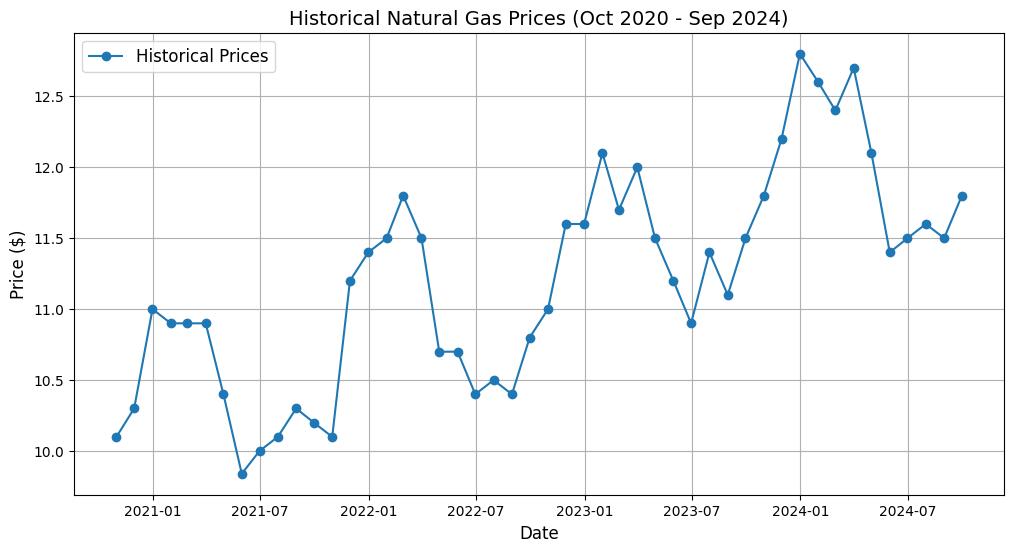

<ipython-input-16-29807d657ebd>:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date + pd.DateOffset(days=1), periods=12, freq='M')


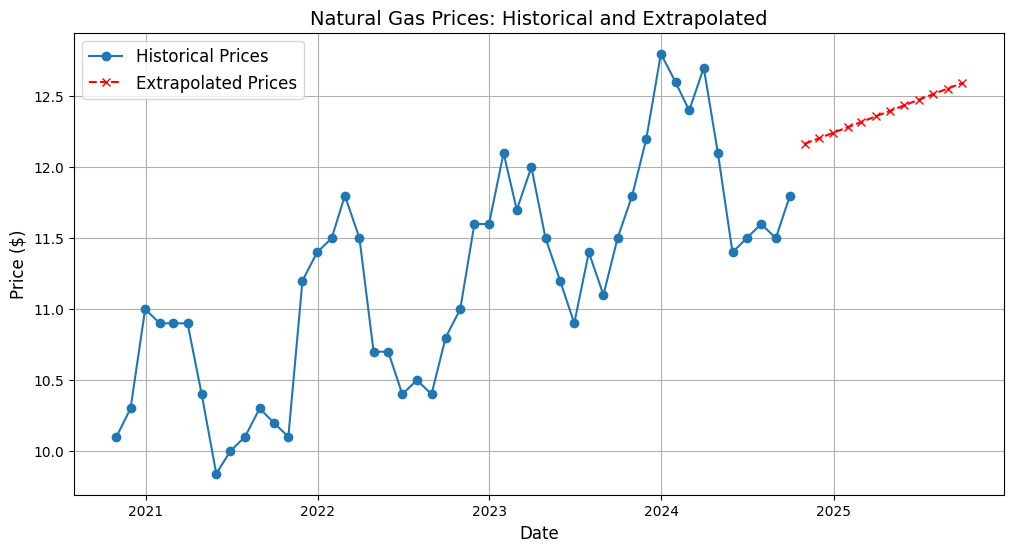


Estimated price = 12.474923364640935


In [ ]:
import pandas as pd

# Load the uploaded file to examine its content
file_path = 'Nat_Gas (1).csv'
nat_gas_data = pd.read_csv(file_path)

# Display the first few rows of the data for review
nat_gas_data.head(), nat_gas_data.info()

import matplotlib.pyplot as plt

# Convert the 'Dates' column to datetime format
nat_gas_data['Dates'] = pd.to_datetime(nat_gas_data['Dates'])

# Plot the historical price data
plt.figure(figsize=(12, 6))
plt.plot(nat_gas_data['Dates'], nat_gas_data['Prices'], marker='o', label='Historical Prices')
plt.title('Historical Natural Gas Prices (Oct 2020 - Sep 2024)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data for modeling
nat_gas_data['Timestamp'] = nat_gas_data['Dates'].map(pd.Timestamp.timestamp)
X = nat_gas_data['Timestamp'].values.reshape(-1, 1)  # Feature: Timestamps
y = nat_gas_data['Prices'].values                  # Target: Prices

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Extrapolate for an additional year (12 months) beyond the last date in the dataset
last_date = nat_gas_data['Dates'].iloc[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(days=1), periods=12, freq='M')
future_timestamps = future_dates.map(pd.Timestamp.timestamp).values.reshape(-1, 1)
future_prices = model.predict(future_timestamps)

# Combine historical and predicted data for visualization
future_data = pd.DataFrame({'Dates': future_dates, 'Prices': future_prices})
all_data = pd.concat([nat_gas_data[['Dates', 'Prices']], future_data], ignore_index=True)

# Plot the historical and extrapolated prices
plt.figure(figsize=(12, 6))
plt.plot(nat_gas_data['Dates'], nat_gas_data['Prices'], marker='o', label='Historical Prices')
plt.plot(future_data['Dates'], future_data['Prices'], marker='x', linestyle='--', color='red', label='Extrapolated Prices')
plt.title('Natural Gas Prices: Historical and Extrapolated', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

def estimate_price(date_str):
    """
    Estimate the price of natural gas for a given date.

    Parameters:
        date_str (str): The date as a string in 'YYYY-MM-DD' format.

    Returns:
        float: Estimated price of natural gas for the given date.
    """
    # Convert input date to timestamp
    input_date = pd.to_datetime(date_str)
    input_timestamp = pd.Timestamp.timestamp(input_date)

    # Predict price using the model
    predicted_price = model.predict([[input_timestamp]])[0]
    return predicted_price

# Example usage: Estimate price for a specific date
example_date = "2025-06-30"
estimated_price = estimate_price(example_date)
print()
print("Estimated price =", estimated_price)

In [ ]:
def price_storage_contract(
    injection_dates,
    withdrawal_dates,
    injection_prices,
    withdrawal_prices,
    injection_rate,
    withdrawal_rate,
    max_volume,
    storage_costs,
):
    """
    Calculate the value of a natural gas storage contract.

    Parameters:
        injection_dates (list of str): Dates for injecting gas in 'YYYY-MM-DD' format.
        withdrawal_dates (list of str): Dates for withdrawing gas in 'YYYY-MM-DD' format.
        injection_prices (list of float): Prices at which gas is purchased on injection dates.
        withdrawal_prices (list of float): Prices at which gas is sold on withdrawal dates.
        injection_rate (float): Rate at which gas can be injected (units/day).
        withdrawal_rate (float): Rate at which gas can be withdrawn (units/day).
        max_volume (float): Maximum volume of gas that can be stored (units).
        storage_costs (float): Daily cost of storing gas (units/day).

    Returns:
        float: Value of the storage contract.
    """
    # Convert dates to datetime for calculation
    injection_dates = pd.to_datetime(injection_dates)
    withdrawal_dates = pd.to_datetime(withdrawal_dates)

    # Ensure prices and dates align
    if len(injection_dates) != len(injection_prices) or len(withdrawal_dates) != len(withdrawal_prices):
        raise ValueError("Dates and prices must align for injection and withdrawal.")

    # Initialize variables
    total_volume = 0
    total_value = 0

    # Process injection transactions
    for date, price in zip(injection_dates, injection_prices):
        inject_volume = min(injection_rate, max_volume - total_volume)  # Limit by available capacity
        total_volume += inject_volume
        total_value -= inject_volume * price  # Deduct cost of buying gas

    # Process withdrawal transactions
    for date, price in zip(withdrawal_dates, withdrawal_prices):
        withdraw_volume = min(withdrawal_rate, total_volume)  # Limit by available stored volume
        total_volume -= withdraw_volume
        total_value += withdraw_volume * price  # Add revenue from selling gas

    # Calculate storage costs over the total period
    total_days = (max(max(injection_dates), max(withdrawal_dates)) - min(min(injection_dates), min(withdrawal_dates))).days
    total_storage_cost = total_days * storage_costs
    total_value -= total_storage_cost  # Deduct storage costs

    return total_value

# Define sample inputs for testing
test_injection_dates = ["2024-10-01", "2024-10-15"]
test_withdrawal_dates = ["2025-01-01", "2025-01-15"]
test_injection_prices = [5.0, 5.5]  # Prices on injection dates
test_withdrawal_prices = [6.5, 7.0]  # Prices on withdrawal dates
test_injection_rate = 10.0  # Units/day
test_withdrawal_rate = 10.0  # Units/day
test_max_volume = 50.0  # Max storage capacity
test_storage_costs = 0.1  # Units/day

contract_value = price_storage_contract(
    injection_dates=test_injection_dates,
    withdrawal_dates=test_withdrawal_dates,
    injection_prices=test_injection_prices,
    withdrawal_prices=test_withdrawal_prices,
    injection_rate=test_injection_rate,
    withdrawal_rate=test_withdrawal_rate,
    max_volume=test_max_volume,
    storage_costs=test_storage_costs,
)

print("Test contract value =", contract_value)

Test contract value = 19.4
